<a href="https://colab.research.google.com/github/SyedUmairHassanKazmi/Image_Captioning_LSTM/blob/main/image_captioning_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

!kaggle datasets download -d hsankesara/flickr-image-dataset

! mkdir flickr30
! unzip flickr-image-dataset.zip -d flickr30

!kaggle datasets download -d syedumairhassankazmi/flickr30k-to-resnet50-dictionary

! mkdir features
! unzip flickr30k-to-resnet50-dictionary.zip -d features

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle (1).json
kaggle.json
flickr-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘flickr30’: File exists
Archive:  flickr-image-dataset.zip
replace flickr30/flickr30k_images/flickr30k_images/1000092795.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: No
N
flickr30k-to-resnet50-dictionary.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘features’: File exists
Archive:  flickr30k-to-resnet50-dictionary.zip
replace features/images_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing Libraries and Turning on TPU

**Importing**

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
import gc
from glob import glob
from PIL import Image
import pickle
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet

import string 
from numpy import array


import sys,warnings 
warnings.filterwarnings("ignore")

from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet50
import cv2 
from glob import glob

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GRU, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

**Code to run on TPU**

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.44.170.234:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.44.170.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.170.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

512


#  Data Preprocessing

In [ ]:
#Image Path
# Image path given ------ used glob to get list of all images
image_path = "/content/flickr30/flickr30k_images/flickr30k_images/"
jpgs = os.listdir(image_path)
images = glob(image_path+'*.jpg')



#Caption Path
# Read the captions with Pandas ---- changed coloumn names
caption_path = '/content/flickr30/flickr30k_images/results.csv'
captions = pd.read_csv(caption_path, sep = '|')
df = pd.DataFrame(captions)
df = df.rename(columns={'image_name' : 'filename',' comment_number': 'index', ' comment': 'caption'}, inplace = False)
df = df.reindex(columns =['index','filename','caption'])
data = df[df['caption'].notnull()]



#Printing DataFrame
# DataFrame name is Data
print("Total Images in Dataset = {}".format(len(jpgs)))
data

Total Images in Dataset = 31785


,index,filename,caption
0,0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1,1000092795.jpg,"Two young , White males are outside near many..."
2,2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...,...
158910,0,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...
158911,1,998845445.jpg,"A young man hanging over the side of a boat ,..."
158912,2,998845445.jpg,A man is leaning off of the side of a blue an...
158913,3,998845445.jpg,"A man riding a small boat in a harbor , with ..."


In [ ]:
# Made a list of images, above list had sets of images, this also has replciated images 
# ( 5 same image paths of 5 captions)
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = image_path + annot
   all_img_name_vector.append(full_image_path)

In [ ]:
#To know lenght of list
len(all_img_name_vector)

158914

### IMAGE FEATURES PREPROCESSING
##### Used all these codes to get images features, made a dictionary out of them 
##### and then saved them
##### commiting all code lines, uploading the file on kaggle and then just loading the dictionary back
##### to save time for multiple runs
##### also for some path reason i ran the image feature code on gpu, will run the rest on tpu

Made a new list which has the filnames for output destination

In [ ]:

# from tqdm import tqdm, tqdm_notebook
# tqdm.pandas()

# def out_path_fn(text):
#     return './image_features/' + str(text)

# data['out_path'] = data['filename'].progress_apply(out_path_fn)
# #data.out_path.values[:6]

# #-----------------------------------------#

# out_path = []
# for path in data["out_path"].astype(str):
#    out_path.append(path)
# out_path = sorted(set(out_path))
# print(out_path[:6])

some code to check code and make directory

In [ ]:
#tf.strings.split(images[0], sep='/')[-1]
#'./image_features/' + tf.strings.split(images[0], sep='/')[-1]
#os.makedirs('./image_features')

Made a fn and a model ---- passed them through a pipeline -------- saved all values ----- made a dictionary --------- saved the dictionary

In [ ]:
# def load_image(image_path):
#    img = tf.io.read_file(image_path)
#    img = tf.image.decode_jpeg(img, channels=3)
#    img = tf.image.resize(img, (224, 224))
#    img = tf.keras.applications.resnet.preprocess_input(img)
#    image_path = './image_features/' + tf.strings.split(image_path, sep='/')[-1]
#    return img, image_path

#extract_model = tf.keras.applications.ResNet50(include_top=True)
#last = extract_model.layers[-2].output
#image_features_extract_model = Model(inputs = extract_model.input,outputs = last)
##image_features_extract_model.summary()

In [ ]:
# images = sorted(images)
# image_dataset = tf.data.Dataset.from_tensor_slices(images)
# image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

In [ ]:
# for img,path in image_dataset.take(3):
#    print(path)

In [ ]:
# %%time
# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                               (2048, )) # batch_features.shape[0], -1, batch_features.shape[3]
#     #print(batch_features)
    
#     for bf, p in zip([batch_features], path):
#         #print(bf, p)
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())
#         #print(path_of_feature, bf.numpy())

In [ ]:
# images_features = {}
# count = 0
# for i in out_path:
#     img_feature = np.load(i + '.npy')
#     img_name = i.split('/')[-1]
    
#     images_features[img_name] = img_feature
# len(images_features)    

In [ ]:
# np.save('images_features.npy',images_features)

Now, reloading the dictionary 

In [ ]:
# URL : https://www.kaggle.com/syedumairhassankazmi/flickr30k-to-resnet50-dictionary
# Inputted the data from the above URL

images_features = np.load('/content/features/images_features.npy' , allow_pickle = True)

In [ ]:
##  get image features dictionary out of numpy ndarray

images_features = np.reshape(images_features, (-1))
images_features = images_features[0]

### get image features list

images_features_list  = list(images_features.values())

In [ ]:
## some code for code checking

print(images_features['10002456.jpg'])
print(len(images_features['10002456.jpg']))
print(len(images_features))


[0.18348733 0.26369268 0.7454376  ... 1.7963673  1.408203   0.01206312]
2048
31783


### Captions Preprocessing

In [ ]:
#Some functions to make cleaner captions

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


In [ ]:
#Applying those functions

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
#Adding start and end token
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
START_TOKEN = '<start> '
END_TOKEN = ' <end>'

def add_start_end(text):
    return START_TOKEN + str(text) + END_TOKEN

data['caption'] = data['caption'].progress_apply(add_start_end)
data.caption.values[:6]

100%|██████████| 158914/158914 [00:00<00:00, 569537.90it/s]


array(['<start>  Two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
       '<start>  Two young White males are outside near many bushes <end>',
       '<start>  Two men in green shirts are standing in yard <end>',
       '<start>  man in blue shirt standing in garden <end>',
       '<start>  Two friends enjoy time spent together <end>',
       '<start>  Several men in hard hats are operating giant pulley system <end>'],
      dtype=object)

In [ ]:
#Making a list of captions out of the pandas dict
captions_list = data['caption']
#captions_list[-20:-10]

In [ ]:
len(captions_list)
#print(captions_dict)

158914

# Tokenizing

In [ ]:
#Tokenizing the captions list and padding them

top_k = 18000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(captions_list)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

captions_list_seq = tokenizer.texts_to_sequences(captions_list)
captions_list_seq = tf.keras.preprocessing.sequence.pad_sequences(captions_list_seq, padding='post')

#Will be used in prediction step
token_start = tokenizer.word_index[START_TOKEN.strip()]
token_end = tokenizer.word_index[END_TOKEN.strip()]


In [ ]:
#A function to get the maximum length of the biggest sentence in the captions list

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(captions_list_seq) 
print(max_length)


74


In [ ]:
#captions_list_seq[:5]

# Train/Val Split

In [ ]:
# Importing some libraries for splitting data
# Since each image has 5 captions so if we randomly shuffle them then some train data
# will leak into the Validation data
# hence we will use kfold groupfold method to make sure each caption of the same image stays in the
# same set

from sklearn.model_selection import KFold, GroupKFold

# 40 splits = 2.5 Val Data
kf = GroupKFold(n_splits=40).split(X=all_img_name_vector, groups=all_img_name_vector)

for ind, (tr, val) in enumerate(kf):
    img_train = np.array(all_img_name_vector)[tr] # np.array make indexing possible
    img_val = np.array(all_img_name_vector)[val]
    
    cap_train =  captions_list_seq[tr]
    cap_val =  captions_list_seq[val]
    
    break

# Image and captions train and validation sets created

In [ ]:
#len(img_val)

In [ ]:
# Function to create a list of image features by 
# mapping image path to it's features using the image_features dictionary

def get_image_encoding(image_ids):
   encoding=[]
   for idx in image_ids:
     encoding.append(images_features[idx.split('/')[-1]])
   return np.array(encoding)

encode_train=get_image_encoding(img_train)
encode_val=get_image_encoding(img_val)

In [ ]:
# Function to create dataset that is to be fed in the model
# Using tensor.data to apply inner function to all of the dataset easily 

def create_dataset(data,labels,batch_size):
  def map_func(img_encode, cap):
    x = {'decoder_input': cap[0:-1],'encoder_input': img_encode}
    y = {'decoder_output': cap[1:]}
    
    return x,y
  
  
  dataset = tf.data.Dataset.from_tensor_slices((data,labels))
  dataset = dataset.map(map_func)
  dataset = dataset.repeat()
  dataset = dataset.shuffle(data.shape[0]).batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

# Model

In [ ]:
# Some Input values, Batch size according to TPU ---- go to top

BATCH_SIZE = BATCH_SIZE
embedding_dim = 512
embedding_size = 512
units = 512
vocab_size = len(tokenizer.word_index) 
max_len = max_length -1
encoder_shape=2048
steps_per_epoch = int(len(img_train) / BATCH_SIZE)


# To train using TPU

with strategy.scope():
        
    #Layers applied to the CNN block of the model
    x_input = Input(shape=(encoder_shape,),name='encoder_input')
    x = Dense(512,activation='relu')(x_input)
    x = RepeatVector(max_len,name='encoder_dense')(x)
    
    #LAyer applied to the RNN block of the model
    y1_input = Input(shape=(None, ), name='decoder_input')
    y1 = Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,input_length=max_len,
                                  name='decoder_embedding')(y1_input)
    y1 = LSTM(units, name='decoder_gru1',
                       return_sequences=True)(y1)
    y1 = LSTM(units, name='decoder_gru2',
                       return_sequences=True)(y1)
    y1 = LSTM(units, name='decoder_gru3',
                       return_sequences=True)(y1)
    y1 = Dropout(0.8)(y1)
    
    #Concatenating the CNN and RNN block and then adding more layers 
    conca = Concatenate()([x, y1])
    y2 = LSTM(1024, return_sequences=True)(conca)
    y2 = Dropout(0.8)(y2)
    y2 = LSTM(512, return_sequences=True)(y2)
    y2 = LSTM(512, return_sequences=True)(y2)
    y2 = Dropout(0.8)(y2)
    y2_output = Dense(vocab_size,
                         activation='linear',
                         name='decoder_output')(y2)

    model = Model(inputs=[x_input, y1_input],
                          outputs=[y2_output])

    model.summary()
    

    model.compile(optimizer=Adam(lr=1e-3),
                  loss= SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy']) 
    
    
    #to stop if validation stops increasing, to increase LR on platue, to save the best model
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3, min_lr=0.001),
    ]


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 512)    9161728     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_gru1 (LSTM)             (None, None, 512)    2099200     decoder_embedding[0][0]          
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 2048)]       0                                            
____________________________________________________________________________________________

In [ ]:
#actually creating the train and val set using the function created above

train_dataset=create_dataset(encode_train,cap_train,BATCH_SIZE)
val_dataset=create_dataset(encode_val,cap_val,BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=50,
          validation_data=val_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_steps=3,
      callbacks=callbacks)

Epoch 1/50
302/302 [==============================] - 130s 325ms/step - loss: 1.2579 - accuracy: 0.8442 - val_loss: 0.9217 - val_accuracy: 0.8562
Epoch 2/50
302/302 [==============================] - 89s 295ms/step - loss: 0.9081 - accuracy: 0.8624 - val_loss: 0.8417 - val_accuracy: 0.8665
Epoch 3/50
302/302 [==============================] - 89s 295ms/step - loss: 0.8416 - accuracy: 0.8686 - val_loss: 0.7938 - val_accuracy: 0.8715
Epoch 4/50
302/302 [==============================] - 89s 295ms/step - loss: 0.8141 - accuracy: 0.8705 - val_loss: 0.7742 - val_accuracy: 0.8732
Epoch 5/50
302/302 [==============================] - 89s 295ms/step - loss: 0.7866 - accuracy: 0.8730 - val_loss: 0.7279 - val_accuracy: 0.8774
Epoch 6/50
302/302 [==============================] - 89s 295ms/step - loss: 0.7585 - accuracy: 0.8752 - val_loss: 0.6978 - val_accuracy: 0.8801
Epoch 7/50
302/302 [==============================] - 89s 295ms/step - loss: 0.7300 - accuracy: 0.8775 - val_loss: 0.6699 - val_a

In [ ]:
#Saving stuff for later use
model.save('model_ImageCap_Umair.h5')
model.save_weights('model_ImageCap_Umair_weights.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Prediction

Predicted caption ['baseball player is playing baseball <end>']
True captions ['<start> two baseball players in blue jerseys and white pants stand on pitcher mound <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']


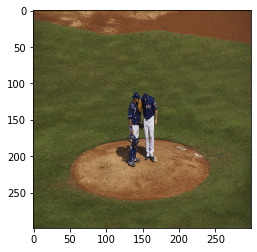

In [ ]:
#Function to load an image from flickr database and predict its caption

def generate_caption(image_id,true_caption,max_tokens=max_len):
    
    encoder_input = images_features[image_id.split('/')[-1]]
    encoder_input = np.expand_dims(encoder_input, axis=0)

    shape = (1, max_tokens)
    decoder_input = np.zeros(shape=shape, dtype=np.int)

    token_id = token_start
  
    output=[]

    count_tokens = 0

    while token_id != token_end and count_tokens < max_tokens:
        
        decoder_input[0, count_tokens] = token_id

        input_data ={'encoder_input':encoder_input ,'decoder_input': decoder_input}
        
        predict = model.predict(input_data)
        
        token_id = np.argmax(predict[0, count_tokens, :])
        
        output.append(token_id)
        
        count_tokens += 1
    
    print('Predicted caption',tokenizer.sequences_to_texts([output]))
    print('True captions',tokenizer.sequences_to_texts([true_caption]))
    
    from tensorflow.keras.preprocessing import image

    def preprocess(image_path):
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        x /= 255.
        return x

    plt.imshow(np.squeeze(preprocess(image_id)))
    

# Change the number to see the results
generate_caption(img_val[200],cap_val[200])

**Code below can be used inside an application or a web browser**
**To predict caption of any image uploaded**

['man in white shirt is sitting at table in kitchen <end>']


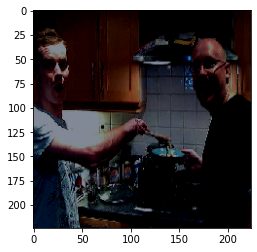

In [ ]:
#Import Librarires
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image



#Import resnet model for feature extraction
extract_model = ResNet50(include_top=True)
last = extract_model.layers[-2].output
image_features_extract_model = Model(inputs = extract_model.input,outputs = last)

#Import the CNN RNN model  
reconstructed_model = load_model("/content/model_ImageCap_Umair.h5")

#Import tokenizor from pickle file
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    

    
#State vocab size, max length(max tokens)
vocab_size = len(tokenizer.word_index) 
max_tokens = 73
START_TOKEN = '<start> '
END_TOKEN = ' <end>'
token_start = tokenizer.word_index[START_TOKEN.strip()]
token_end = tokenizer.word_index[END_TOKEN.strip()]


#Import the file, incase of an application the user will upload the file here
image_path = '/content/flickr30/flickr30k_images/flickr30k_images/1000366164.jpg'

#Presprocess the image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
image = tf.keras.applications.resnet.preprocess_input(x)

#Use the prediction coding,extarct image features from ResNet50 model and RNN features from ------>
#Reconstructed model, use that model to predict
encoder_input = image_features_extract_model.predict(image)
encoder_input = tf.reshape(encoder_input,
                             (2048, ))

encoder_input = np.expand_dims(encoder_input, axis=0)

shape = (1, max_tokens)
decoder_input = np.zeros(shape=shape, dtype=np.int)

token_id = token_start

output=[]

count_tokens = 0

while token_id != token_end and count_tokens < max_tokens:
    
    decoder_input[0, count_tokens] = token_id

    input_data ={'encoder_input':encoder_input ,'decoder_input': decoder_input}
    
    predict = reconstructed_model.predict(input_data)
    
    token_id = np.argmax(predict[0, count_tokens, :])
    
    output.append(token_id)
    
    count_tokens += 1

#Print prediction    
final = tokenizer.sequences_to_texts([output])
print(final)
#Print Image
plt.imshow(np.squeeze(x /255.))